# NHL Jets - Event Propensity - Next Event Buyer Model
* Ryan Kazmerik, Nakisa Rad, Joey Lai, Shawn Sutherland, Matt Bahler, Pat Faith
* Mar 03, 2022

## Hypothesis
Each team has different tier (or quality) of games, based on day of the week, time of the season, opponent, etc. We think that by using previous buyer behaviour we can make a prediction on whether the fan will purchase for the next game or not.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import matplotlib.pyplot as plt
import pyodbc
import pandas as pd
import warnings

from pycaret.classification import *

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189'  
DATABASE = 'stlrNHLJets' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [5]:
lkupclientid = 92

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrNHLJets].[ds].[PropensityEventTraining] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)
    
CNXN.commit()
cursor.close()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63662 entries, 0 to 63661
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   daysOut              63662 non-null  object        
 1   minDaysOut           63662 non-null  int64         
 2   maxDaysOut           34611 non-null  float64       
 3   dimCustomerMasterId  63662 non-null  int64         
 4   recent_openRate      63662 non-null  float64       
 5   recent_clickRate     63662 non-null  float64       
 6   eventDate            63662 non-null  datetime64[ns]
 7   eventName            63662 non-null  object        
 8   inMarket             57010 non-null  object        
 9   distanceToVenue      56118 non-null  float64       
 10  tenure               63662 non-null  int64         
 11  did_purchase         63662 non-null  int64         
 12  events_purchased     63662 non-null  int64         
 13  frequency_opponent   63662 non-

### We should create separate out some data for training the model and some for evaluating:

In [7]:
# copy your main dataframe
df_dataset = df

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True)
df_eval.reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

df_train.info()

Data for Modeling: (54113, 17)
Unseen Data For Predictions: (9549, 17)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54113 entries, 47082 to 34843
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   daysOut              54113 non-null  object        
 1   minDaysOut           54113 non-null  int64         
 2   maxDaysOut           29433 non-null  float64       
 3   dimCustomerMasterId  54113 non-null  int64         
 4   recent_openRate      54113 non-null  float64       
 5   recent_clickRate     54113 non-null  float64       
 6   eventDate            54113 non-null  datetime64[ns]
 7   eventName            54113 non-null  object        
 8   inMarket             48446 non-null  object        
 9   distanceToVenue      47670 non-null  float64       
 10  tenure               54113 non-null  int64         
 11  did_purchase         54113 non-null  int64         
 12  events_purch

### Now we can model the data using a binary classification prediction for the target field to see how likely a customer is to purchase:

In [8]:
setup(
    data= df_train, 
    target="did_purchase", 
    train_size = 0.80,
    data_split_shuffle=True,
    categorical_features=["inMarket"],
    date_features=["eventDate"],
    ignore_features=[
        "dimCustomerMasterId",
        "eventName",
        "minDaysOut",
        "maxDaysOut"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "distanceToVenue",
        "events_purchased",
        "frequency_eventDay",
        "frequency_opponent",
        "frequency_eventTime",
        "recent_clickRate",
        "recent_openRate",
        "tenure"
    ]
);

In [9]:
model_matrix = compare_models(
    fold= 10, 
    include= ["lr"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7597,0.8406,0.7361,0.7727,0.7539,0.5194,0.5200,1.5830


### The top model is performing well, so let's compare it against our test dataset:

In [10]:
best_model = create_model(
    model_matrix, 
    fold= 10
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7621,0.8408,0.7413,0.7735,0.7571,0.5241,0.5246
1,0.7510,0.8317,0.7307,0.7617,0.7459,0.5020,0.5024
2,0.7651,0.8429,0.7381,0.7803,0.7586,0.5302,0.5309
3,0.7607,0.8416,0.7418,0.7710,0.7561,0.5214,0.5217
4,0.7510,0.8315,0.7270,0.7637,0.7449,0.5020,0.5025
5,0.7517,0.8396,0.7173,0.7703,0.7429,0.5034,0.5046
6,0.7706,0.8523,0.7484,0.7835,0.7655,0.5412,0.5418
7,0.7665,0.8471,0.7415,0.7807,0.7606,0.5329,0.5336
8,0.7549,0.8355,0.7276,0.7699,0.7482,0.5098,0.5106
9,0.7635,0.8435,0.7470,0.7727,0.7596,0.5269,0.5272


### Let's load in our evaluation data and get propensity scores using the model:

In [11]:
df_inference = predict_model(best_model, data=df_eval, raw_score=True)
df_inference.head()

,daysOut,minDaysOut,maxDaysOut,dimCustomerMasterId,recent_openRate,recent_clickRate,eventDate,eventName,inMarket,distanceToVenue,tenure,did_purchase,events_purchased,frequency_opponent,frequency_eventDay,frequency_eventTime,count_merchOwned,Label,Score_0,Score_1
5,1 to 3 Days Out,1,4.0,2598,0.0,0.0,2014-12-21,20141221 - Philadelphia Flyers,True,3.03,78,1,16,0.000000,0.250000,0.076923,0,1,0.2651,0.7349
12,1 to 3 Days Out,1,4.0,3252,0.0,0.0,2018-09-23,20180923 - Edmonton Oilers,True,20.57,1007,0,117,0.000000,0.050000,0.009346,0,0,0.7987,0.2013
14,1 to 3 Days Out,1,4.0,4418,0.0,0.0,2018-02-16,20180216 - Colorado Avalanche,True,13.92,861,1,117,0.166667,0.071429,0.076190,0,1,0.4618,0.5382
18,1 to 3 Days Out,1,4.0,5898,0.0,0.0,2022-02-19,20220219 - Edmonton Oilers,False,709.89,1569,0,144,0.000000,0.000000,0.000000,0,0,0.9108,0.0892
31,1 to 3 Days Out,1,4.0,11581,0.0,0.0,2017-11-27,20171127 - Minnesota Wild,True,7.75,1096,0,134,0.000000,0.000000,0.016807,0,0,0.6708,0.3292


### Included are some metrics on did and did_not purchase:

In [12]:
did_purchase = df_inference["Label"].value_counts()[1]
did_not_purchase = df_inference["Label"].value_counts()[0]
total_rows = df_inference["Label"].count()
purchase_percentage = round((did_purchase / total_rows), 2) * 100

print("Would purchase:", did_purchase)
print("Would not purchase:", did_not_purchase)
print("Purchase percentage:", purchase_percentage)

Would purchase: 4590
Would not purchase: 4959
Purchase percentage: 48.0


### We can also see the correlation between the features and the target variable:

In [22]:
cor = df.corr()

df_correlated = df

corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,minDaysOut,maxDaysOut,dimCustomerMasterId,recent_openRate,recent_clickRate,distanceToVenue,tenure,did_purchase,events_purchased,frequency_opponent,frequency_eventDay,frequency_eventTime,count_merchOwned
minDaysOut,1.00,0.98,-0.03,-0.03,-0.02,-0.03,-0.06,0.36,-0.04,0.14,0.14,0.13,0.01
maxDaysOut,0.98,1.00,-0.03,-0.00,-0.00,0.02,0.03,-0.11,0.02,-0.02,-0.03,-0.04,0.00
dimCustomerMasterId,-0.03,-0.03,1.00,-0.01,-0.00,0.05,-0.01,-0.01,-0.01,0.06,0.08,0.11,-0.01
recent_openRate,-0.03,-0.00,-0.01,1.00,0.02,-0.02,0.03,-0.00,0.03,-0.00,0.00,0.01,0.04
recent_clickRate,-0.02,-0.00,-0.00,0.02,1.00,-0.01,0.02,0.01,0.02,-0.01,-0.00,-0.00,0.01
distanceToVenue,-0.03,0.02,0.05,-0.02,-0.01,1.00,-0.02,-0.12,-0.04,-0.04,-0.06,-0.06,-0.02
tenure,-0.06,0.03,-0.01,0.03,0.02,-0.02,1.00,-0.24,0.97,-0.03,-0.15,-0.21,0.11
did_purchase,0.36,-0.11,-0.01,-0.00,0.01,-0.12,-0.24,1.00,-0.20,0.24,0.28,0.33,-0.00
events_purchased,-0.04,0.02,-0.01,0.03,0.02,-0.04,0.97,-0.20,1.00,-0.01,-0.13,-0.18,0.09
frequency_opponent,0.14,-0.02,0.06,-0.00,-0.01,-0.04,-0.03,0.24,-0.01,1.00,0.32,0.36,-0.01


### Here we can see the distribution of fans who did and did not purchase : Score_0 = Did Not Purchase, Score_1 = Did Purchase

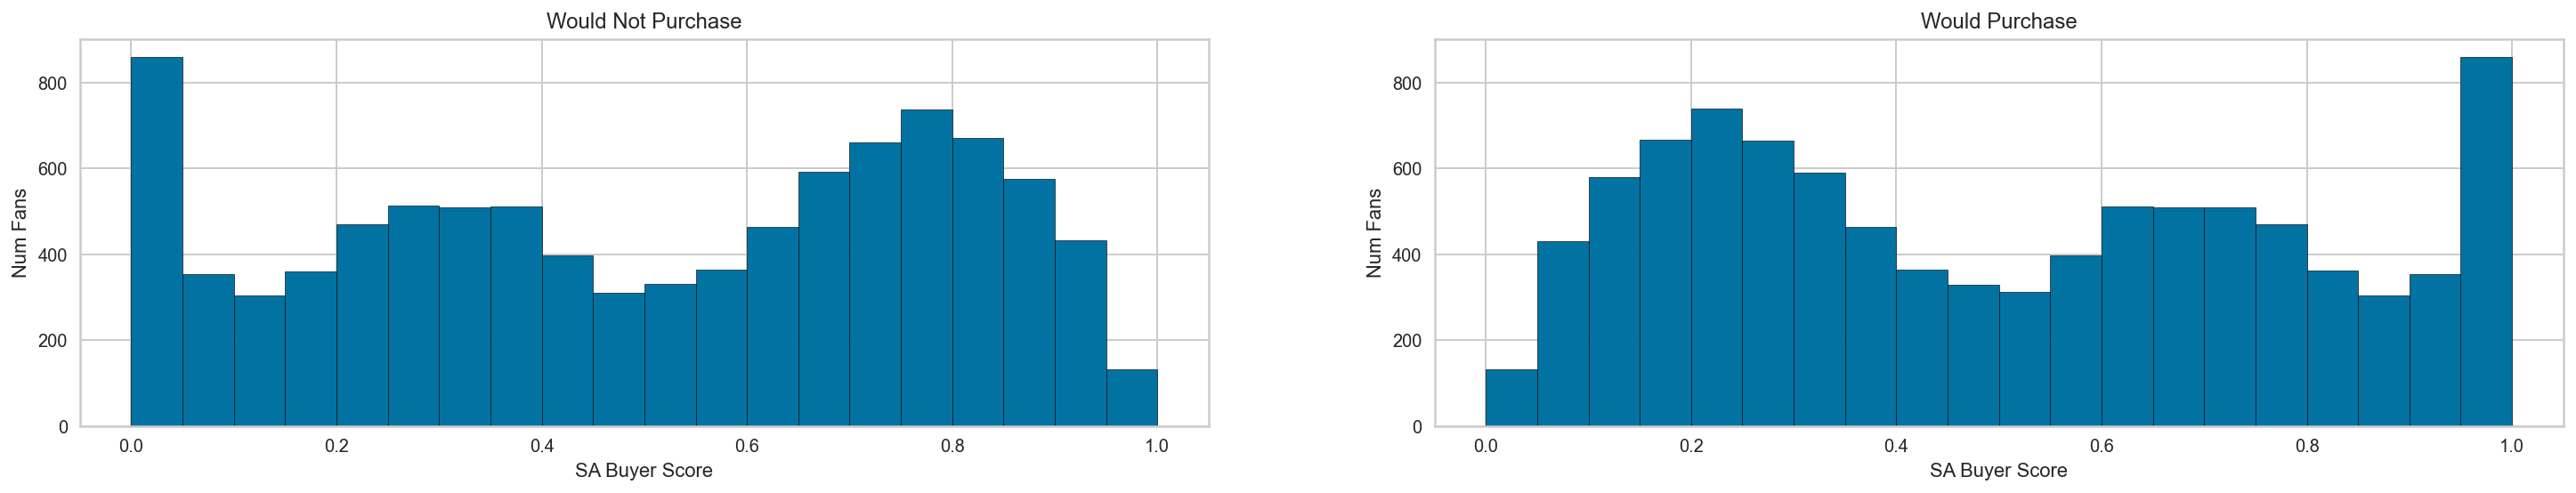

In [21]:
plt.subplot(1, 2, 1)
plt.title("Would Not Purchase")
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")
plt.hist(df_inference["Score_0"], bins=20, edgecolor="black", range=(0,1))

plt.subplot(1, 2, 2)
plt.title("Would Purchase")
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")
plt.hist(df_inference["Score_1"], bins=20, edgecolor="black", range=(0,1))

plt.rcParams["figure.figsize"] = (25,4)
plt.show()

### This plot lists the most important features for a correct prediction (either Score_0 or Score_1) in the model:

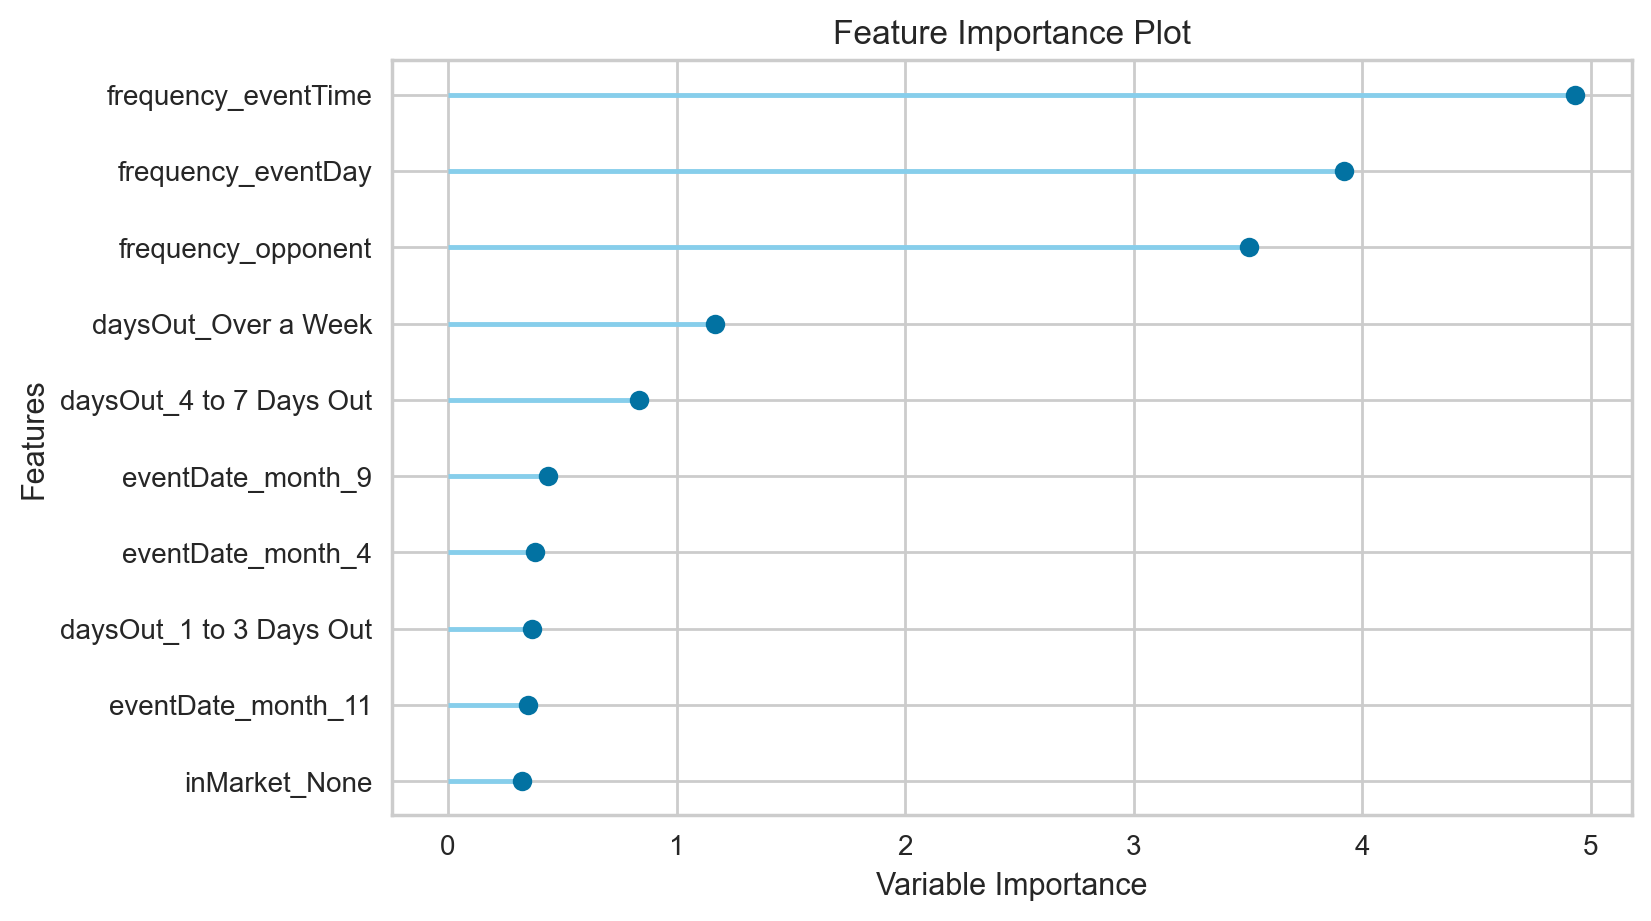

In [15]:
plot_model(best_model, plot='feature')

### This confusion matrix helps understand where the model guessed correctly or incorrectly based on the evaluation data:

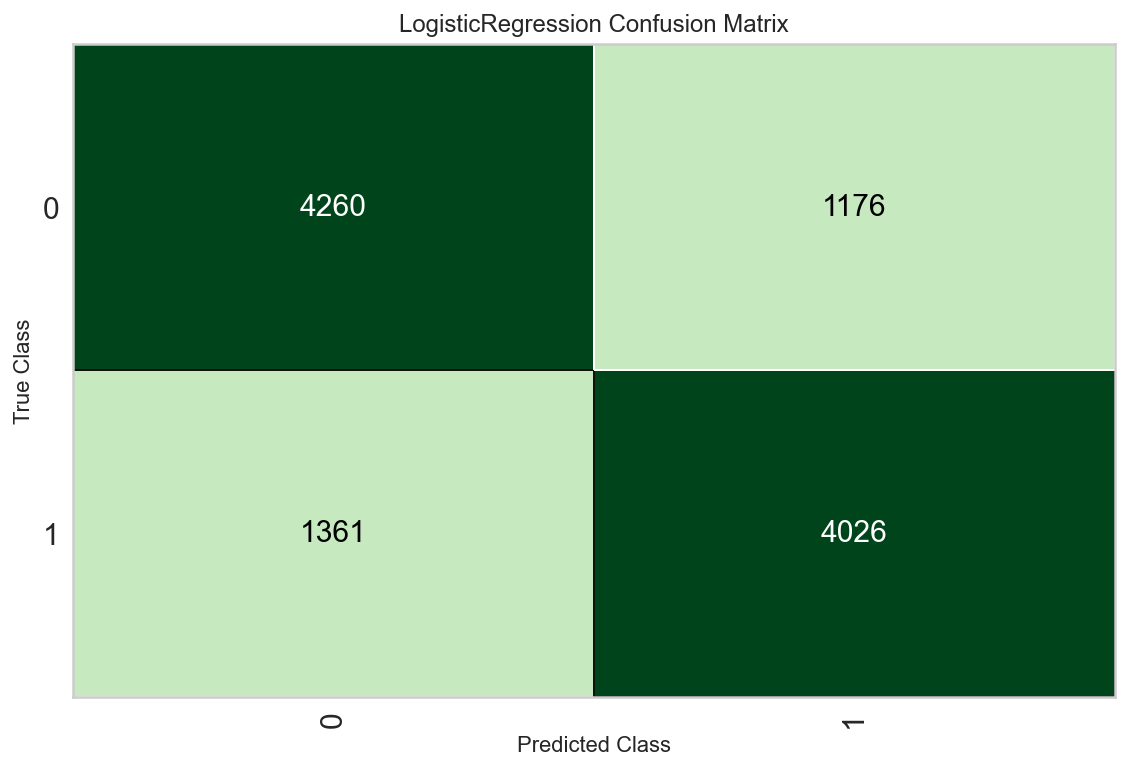

In [16]:
plot_model(best_model, plot='confusion_matrix')

### The AUC curve tells how much the model is capable of distinguishing between classes. The higher the curve, the better the model is at distiguishing classes:

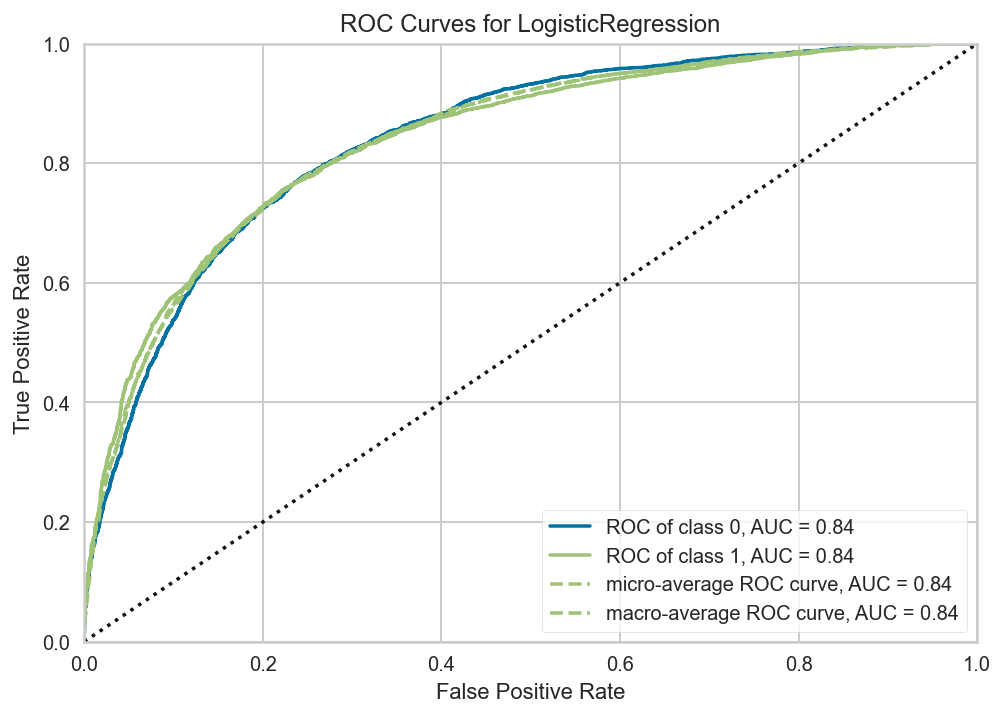

In [17]:
plot_model(best_model, plot='auc')

### Now we can save the model so in the future we can run different datasets through the model for predictions:

In [ ]:
save_model(best_model,'./models/NHL Jets - Event Propensity(04Mar2022)')

## Observations
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?